# Logistic Regression using Newton's Method - Assignment 4

1. Using the data set of two examination results design a predictor using logistic regression with delta learning rule using Newton’s method for predicting whether a student can get an admission in the institution and compare the results with Logistic regression(using gradient descent).

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from matplotlib import animation, rc

### Read the data

In [3]:
data = pd.read_csv('data set for two exam results.csv')
#data = data.sample(frac=1).reset_index(drop=True)
np.random.seed(10)
data.head()

,t1,t2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### Normalize the data

In [4]:
x = np.array(data.iloc[:,[0,1]])
y = np.array(data.iloc[:,2]).reshape(-1,1)
ran = x.max(axis=0) - x.min(axis=0)
x = (x - x.min(axis=0)) / ran
x = np.insert(x, 0, 1,axis = 1)
x[:5]

array([[1.        , 0.06542784, 0.69465488],
       [1.        , 0.00326632, 0.19470455],
       [1.        , 0.08296784, 0.61961779],
       [1.        , 0.43176427, 0.81600135],
       [1.        , 0.7019434 , 0.65539214]])

## Adding Polynomial Features

Added $X_1^2$, $X_2^2$ and $X_1 X_2$ terms

In [5]:
x = np.insert(x,3,x[:,1]**2,axis=1)
x = np.insert(x,4,x[:,2]**2,axis=1)
x = np.insert(x,5,x[:,1] * x[:,2],axis=1)

### Split the data to train & test (70 - 30 split)

In [6]:
d = int(y.shape[0] * 0.7)
xtrain = x[:d]
xtest = x[d:]
ytrain = y[:d]
ytest = y[d:]

### Cost function

In [7]:
def cost(x,y,w,lamb=0):
    h = 1/ (1 + np.exp(- np.matmul(x,w)))
    n = np.where(y==0)
    p = np.where(y==1)
    cost = - np.log(h[p]).sum() -  np.log(1 - h[n]).sum() 
    return (cost + lamb * np.dot(w.T,w)[0,0]) / y.shape[0]

## Accuracy

In [8]:
def accuracy(x, y, w):
    h = np.dot(x, w) > 0
    e = np.abs(h - y).sum()
    return 1 - (e)/len(y)

### Predict
Given any 2 points predict function returns the probablity of the given point being positive or negative class

In [9]:
def predict(x,w):
    t = np.insert(x,0,1,axis=1) 
    T = np.insert(t,3,t[:,1]**2,axis=1)
    T = np.insert(T,4,t[:,2]**2,axis=1)
    T = np.insert(T,5,t[:,1] * t[:,2],axis=1)
    Z = 1/ (1 + np.exp(- np.matmul(T,w))) 
    return  Z

### Plotting

In [10]:
def plot(x,y,w,title):
    h = .005  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = x[:, 1].min() - .1, x[:, 1].max() + .1
    y_min, y_max = x[:, 2].min() - .1, x[:, 2].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    Z = predict(np.c_[xx.ravel(), yy.ravel()],w)

    Z = Z.reshape(xx.shape)
    plt.title(title)
    plt.xlabel('Test 1')
    plt.ylabel('Test 2')
    plt.scatter(x[:,1], x[:,2],c=y.reshape(-1,))
    CS = plt.contour(xx, yy, Z,levels=[0.5],colors=('r',))
    #plt.clabel(CS, colors = 'r', fontsize=10)
    plt.show()

# Newton's Method

In [11]:
def newton_method(x, y, lamb=0.01, iterations=1):
    m = y.shape[0]
    cost_list = []
    w_list = []
    Lamb = lamb * np.eye(x.shape[1])
    Lamb[0,0] = 0
    np.random.seed(10)
    #w = np.ones((x.shape[1],1))
    w = np.random.randn(x.shape[1]).reshape(-1,1)
    for i in range(iterations):
        h = 1/ (1 + np.exp(- np.matmul(x,w)))
        grad = (np.dot(x.T,(h - y)) + Lamb @ w) / m
        hessian = ((((h * (1 - h) ) * x).T @ x) + Lamb) / m
        h_inv = np.linalg.pinv(hessian)
        w_list.append(grad)
        w = w -  (h_inv @ grad) 
        cost_list.append(cost(x,y,w,0))
    return cost_list,w_list, w

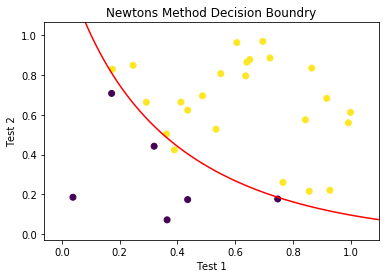

Accuracy: 0.9666666666666667


In [12]:
cost_list,w_list, w = newton_method(xtrain, ytrain,0.01,8)
a = accuracy(xtest,ytest,w)
plot(xtest,ytest,w,'Newtons Method Decision Boundry')
print("Accuracy: "+ str(a))

Text(0.5, 0, 'No of iterations')

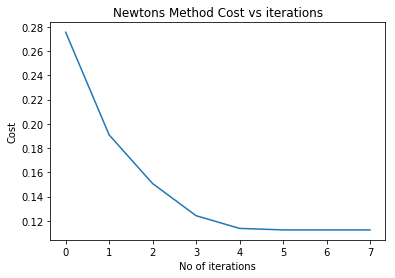

In [13]:
plt.plot(cost_list)
plt.title('Newtons Method Cost vs iterations')
plt.ylabel('Cost')
plt.xlabel('No of iterations')

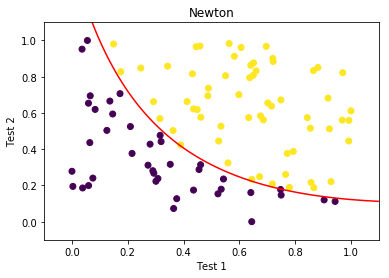

Accuracy: 1.0


In [14]:
cost_list,w_list, w = newton_method(xtrain, ytrain,0.001,20)
a = accuracy(xtest,ytest,w)
plot(x,y,w,'Newton')
print("Accuracy: "+ str(a))

As it is seen it Converges very fast ie around 4 iterations

### Gradient descent 

In [15]:
def gradient_descent(x, y, alpha, iterations, lamb=0):
    m = y.shape[0]
    cost_list = []
    w_list = []
    w = np.random.randn(x.shape[1]).reshape(-1,1)
    #w = np.zeros((x.shape[1],1))
    for i in range(iterations):
        h = 1/ (1 + np.exp(- np.matmul(x,w))) 
        w1 = np.array(w,copy=True)
        w1[0,0]= 0
        grad = np.dot(x.T,(h - y)) + lamb * w1
        w_list.append(np.array(w,copy=True))
        w = w - (alpha/m) * grad
        if (np.abs(grad) > 0.01).sum() == 0:
            break
        cost_list.append(cost(x,y,w,lamb))
    return cost_list, w_list, w

### Calling GD with alpha = 0.25 and iterations = 12000

In [50]:
cost_list, w_list, w = gradient_descent(xtrain, ytrain, 0.25, 20000,0.01)

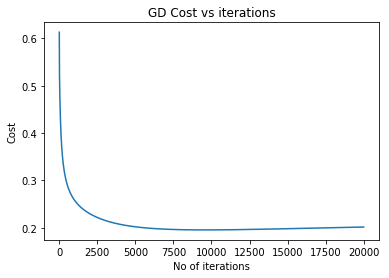

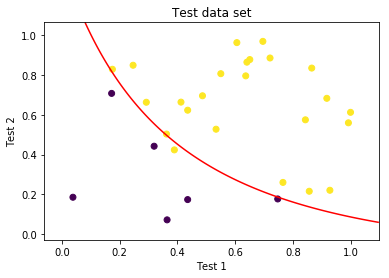

Accuracy: 0.9666666666666667


In [51]:
plt.title('GD Cost vs iterations')
plt.ylabel('Cost')
plt.xlabel('No of iterations')
plt.plot(cost_list[:])
plt.show()
a = accuracy(xtest,ytest,w)
plot(xtest,ytest,w,'Test data set')
print("Accuracy: "+ str(a))

# Visualising the updation of decision Boundry

In [18]:
def play(x, w_list,frames,inter,lin=True):
    fig, ax = plt.subplots()
    x_min, x_max = x[:, 1].min() - .1, x[:, 1].max() + .1
    y_min, y_max = x[:, 2].min() - .1, x[:, 2].max() + .1

    ax.set_xlim(( x_min, x_max))
    ax.set_ylim((y_min, y_max))
    plt.title('Decision Boundry Updation')
    plt.xlabel('Exam 1')
    plt.ylabel('Exam 2')
    plt.scatter(x[:,1], x[:,2],c=y.reshape(-1,))

    line, = ax.plot([], [], lw=2)
    def init():
        line.set_data([], [])
        return (line,)

    def animateL(i):
        l = len(w_list)
        k = (5 * i + (i **2)//8 ) % l
        x = np.linspace(x_min, x_max, 100)
        w = w_list[k]
        y = (-w[0,0] -w[1,0] * x)/w[2,0]
        line.set_data(x, y)
        return (line,)
    
    def animate(i):
        l = len(w_list)
        w = w_list[(2 * i) % l]
        xb1 = np.linspace(x_min, x_max, 60)
        xb2 = np.linspace(y_min, y_max, 60)
        Xb1, Xb2 = np.meshgrid(xb1,xb2)
        b = w[0,0] + w[1,0] * Xb1 + w[2,0] * Xb2 + w[3,0] * Xb1**2 + w[4,0] * Xb2**2 + w[5,0] * Xb1 * Xb2
        cs = ax.contour(Xb1,Xb2,b,[0],colors='w', linewidths=0.01)
        dat0= cs.allsegs[0][0]
        #plt.plot(dat0[:,0],dat0[:,1])    
        plt.show()
        x1 = dat0[:,0]
        y1 = dat0[:,1]
        line.set_data(x1, y1)
        return (line,)
    k = animate
    if lin:
        k = animateL
    anim = animation.FuncAnimation(fig, k, init_func=init,
                                   frames=frames, interval=inter, 
                                   blit=True)
    return anim

/home/aadithya/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


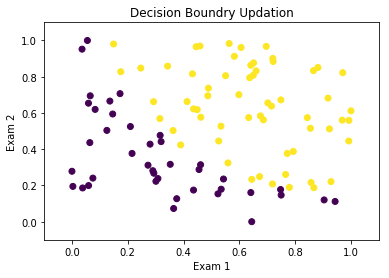

In [19]:
anim = play(x, w_list,200,90,lin=False)
anim.save('Curve2.gif', dpi=80, writer='imagemagick')
Image(url='./Curve2.gif')

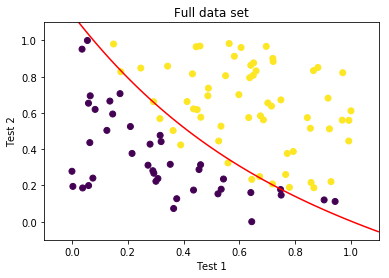

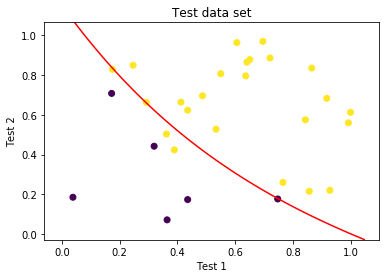

In [20]:
plot(x,y,w,'Full data set')
plot(xtest,ytest,w,'Test data set')

In [21]:
accuracy(xtest,ytest,w)

0.9

## Expirements

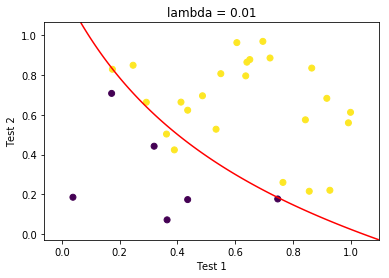

Accuracy: 0.9


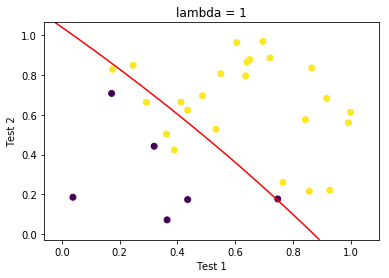

Accuracy: 0.8333333333333334


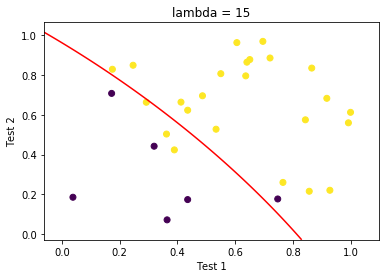

Accuracy: 0.8666666666666667


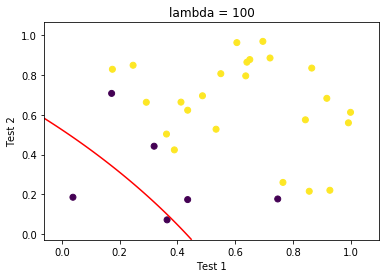

Accuracy: 0.8666666666666667


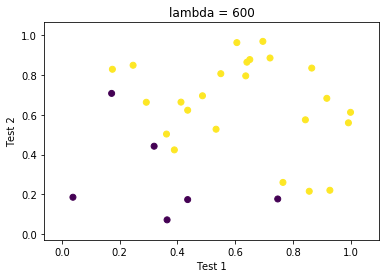

Accuracy: 0.8


In [24]:
for i in [0.01,1,15,100,600]:
    cost_list, grad_list, w = gradient_descent(xtrain, ytrain, 0.15, 8000,i)
    a = accuracy(xtest,ytest,w)
    plot(xtest,ytest,w,'lambda = '+ str(i))
    print("Accuracy: "+ str(a))
